In [ ]:
# Setup and imports
import sys
import os
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Set project root
project_root = Path("/home/Plutonium/Documents/BioinfoMidterm")
os.chdir(project_root)
sys.path.insert(0, str(project_root / "scripts"))

print(f"Working directory: {os.getcwd()}")

# Import config module and set population FIRST
import config as cfg
cfg.set_population_config("khv_jpt_chb")

# Now create aliases (pointing to updated config)
PATHS = cfg.PATHS
ML = cfg.ML
POPULATIONS = cfg.POPULATIONS

# Core imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

# ML imports
from sklearn.model_selection import (
    train_test_split, cross_val_score, StratifiedKFold, cross_validate
)
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import (
    classification_report, confusion_matrix, accuracy_score,
    precision_score, recall_score, f1_score, make_scorer
)

# Classifiers
from sklearn.ensemble import (
    RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
)
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier

print("All imports successful!")

Working directory: /home/Plutonium/Documents/BioinfoMidterm
All imports successful!


## Step 1: Load Data and Identify Consensus SNPs

In [2]:
# Load statistical results from 02b
stats_path = str(PATHS.OUTPUT_DIR / "statistical_snp_scores_02b.csv")
print(f"Loading statistical results from: {stats_path}")

stats_df = pd.read_csv(stats_path)
print(f"Statistical results: {stats_df.shape}")

# Load genotype data
ml_data_path = str(PATHS.OUTPUT_DIR / "statistical_ml_data_02b.csv")
print(f"Loading genotype data from: {ml_data_path}")

df = pd.read_csv(ml_data_path)
print(f"Genotype data: {df.shape}")
print(f"\nPopulation distribution:")
print(df['pop'].value_counts())

Loading statistical results from: 1000genomes/output/statistical_snp_scores_02b.csv
Statistical results: (390615, 15)
Loading genotype data from: 1000genomes/output/statistical_ml_data_02b.csv
Genotype data: (306, 39)

Population distribution:
pop
JPT    104
CHB    103
KHV     99
Name: count, dtype: int64


In [3]:
# Load pre-filtered consensus SNPs from 02b (passed all 4 tests)
all4_snps_path = str(PATHS.OUTPUT_DIR / "statistical_all4_snps_02b.csv")
print(f"Loading consensus SNPs from: {all4_snps_path}")

all4_df = pd.read_csv(all4_snps_path)
consensus_snps = all4_df['snp_id'].tolist()

print(f"Consensus SNPs (all 4 tests): {len(consensus_snps)}")
print(f"\nFirst 10 consensus SNPs:")
for snp in consensus_snps[:10]:
    print(f"  - {snp}")

Loading consensus SNPs from: 1000genomes/output/statistical_all4_snps_02b.csv
Consensus SNPs (all 4 tests): 37

First 10 consensus SNPs:
  - 4:101002868[b37]A,T
  - 14:96938945[b37]A,T
  - 4:17813761[b37]G,A
  - 1:12387655[b37]G,A
  - 5:41181491[b37]G,T
  - 12:128054516[b37]C,T
  - 3:130239945[b37]G,A
  - 6:37497412[b37]C,T
  - 16:10424828[b37]A,G
  - 1:168205652[b37]G,A


In [4]:
# Filter to available SNPs in genotype data
snp_columns = [c for c in df.columns if c not in ['sample', 'pop']]
available_consensus = [s for s in consensus_snps if s in snp_columns]

print(f"Available consensus SNPs in data: {len(available_consensus)}")

# Prepare data
X = df[available_consensus].values
y = df['pop'].values

# Encode labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)

print(f"\nFeature matrix: {X.shape}")
print(f"Classes: {le.classes_}")
print(f"Class distribution: {dict(zip(le.classes_, np.bincount(y_encoded)))}")

Available consensus SNPs in data: 37

Feature matrix: (306, 37)
Classes: ['CHB' 'JPT' 'KHV']
Class distribution: {'CHB': np.int64(103), 'JPT': np.int64(104), 'KHV': np.int64(99)}


## Step 2: PCA Visualization on Consensus SNPs

In [5]:
# Standardize for PCA
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# PCA
pca = PCA(n_components=min(10, len(available_consensus)))
X_pca = pca.fit_transform(X_scaled)

print(f"PCA on {len(available_consensus)} Consensus SNPs:")
print(f"  Explained variance ratio: {pca.explained_variance_ratio_[:3]}")
print(f"  Total variance (3 PCs): {sum(pca.explained_variance_ratio_[:3]):.4f}")

PCA on 37 Consensus SNPs:
  Explained variance ratio: [0.20025698 0.07813023 0.04529669]
  Total variance (3 PCs): 0.3237


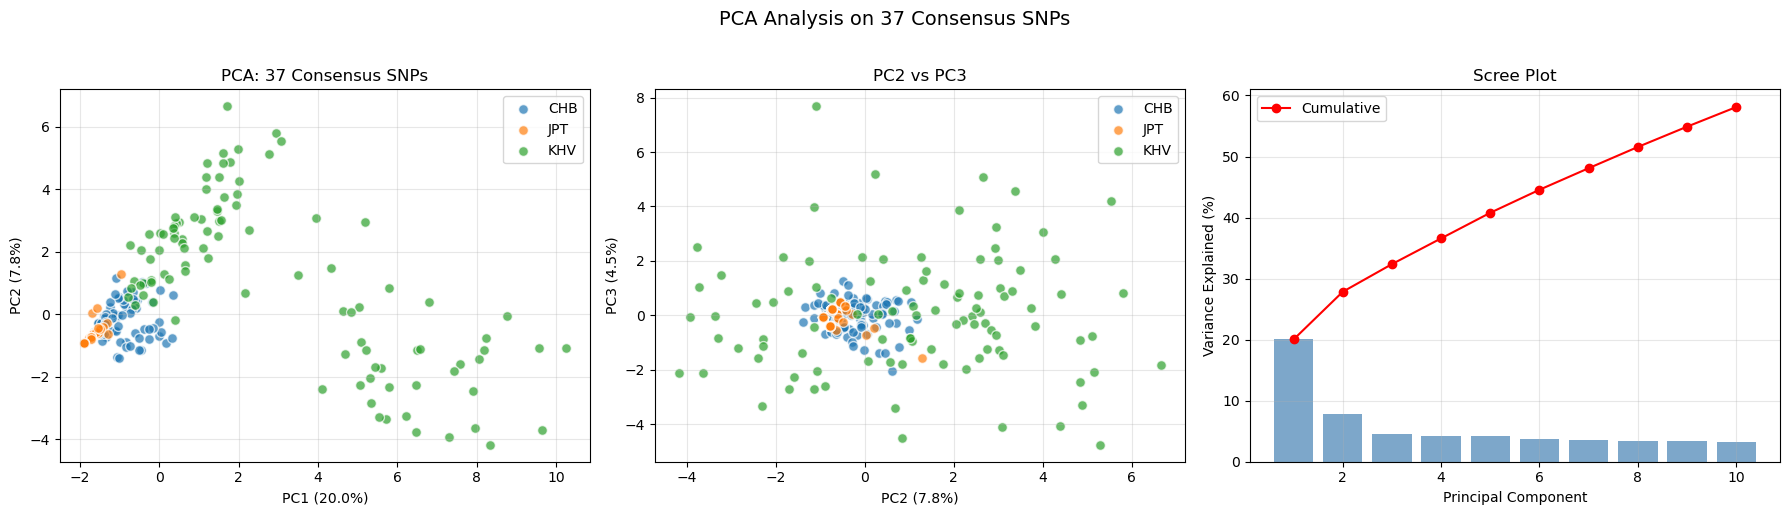

In [6]:
# PCA visualization
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

colors = {'CHB': '#1f77b4', 'JPT': '#ff7f0e', 'KHV': '#2ca02c'}

# Plot 1: PC1 vs PC2
ax = axes[0]
for pop in le.classes_:
    mask = y == pop
    ax.scatter(X_pca[mask, 0], X_pca[mask, 1], 
               c=colors.get(pop, 'gray'), label=pop, alpha=0.7, s=50, edgecolors='white')
ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)')
ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)')
ax.set_title(f'PCA: {len(available_consensus)} Consensus SNPs')
ax.legend()
ax.grid(True, alpha=0.3)

# Plot 2: PC2 vs PC3
ax = axes[1]
for pop in le.classes_:
    mask = y == pop
    ax.scatter(X_pca[mask, 1], X_pca[mask, 2], 
               c=colors.get(pop, 'gray'), label=pop, alpha=0.7, s=50, edgecolors='white')
ax.set_xlabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)')
ax.set_ylabel(f'PC3 ({pca.explained_variance_ratio_[2]*100:.1f}%)')
ax.set_title('PC2 vs PC3')
ax.legend()
ax.grid(True, alpha=0.3)

# Plot 3: Scree plot
ax = axes[2]
n_pcs = len(pca.explained_variance_ratio_)
ax.bar(range(1, n_pcs+1), pca.explained_variance_ratio_ * 100, color='steelblue', alpha=0.7)
ax.plot(range(1, n_pcs+1), np.cumsum(pca.explained_variance_ratio_) * 100, 'ro-', label='Cumulative')
ax.set_xlabel('Principal Component')
ax.set_ylabel('Variance Explained (%)')
ax.set_title('Scree Plot')
ax.legend()
ax.grid(True, alpha=0.3)

plt.suptitle(f'PCA Analysis on {len(available_consensus)} Consensus SNPs', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

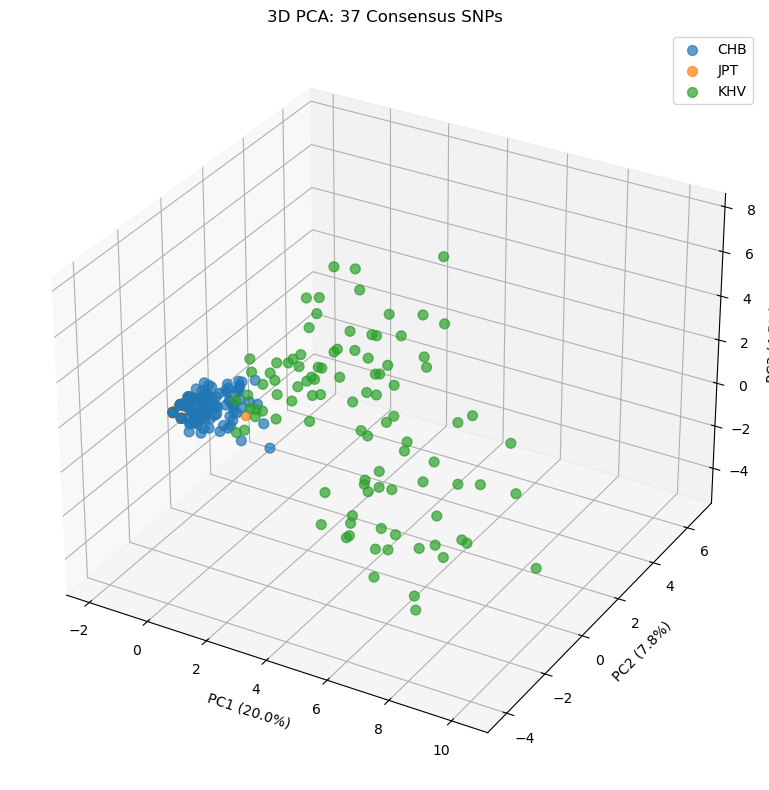

In [7]:
# 3D PCA plot
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

for pop in le.classes_:
    mask = y == pop
    ax.scatter(X_pca[mask, 0], X_pca[mask, 1], X_pca[mask, 2],
               c=colors.get(pop, 'gray'), label=pop, alpha=0.7, s=50)

ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)')
ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)')
ax.set_zlabel(f'PC3 ({pca.explained_variance_ratio_[2]*100:.1f}%)')
ax.set_title(f'3D PCA: {len(available_consensus)} Consensus SNPs')
ax.legend()

plt.tight_layout()
plt.show()

## Step 3: Train All Classifiers with K-Fold Cross-Validation

In [ ]:
# Define classifiers
classifiers = {
    'Random Forest': RandomForestClassifier(
        n_estimators=100, max_depth=10, random_state=42, n_jobs=-1
    ),
    'XGBoost': XGBClassifier(
        n_estimators=100, max_depth=5, learning_rate=0.1, 
        random_state=42, n_jobs=-1, verbosity=0
    ),
    'Logistic Regression': LogisticRegression(
        max_iter=1000, random_state=42, multi_class='multinomial', n_jobs=-1
    ),
    'SVM (RBF)': SVC(
        kernel='rbf', random_state=42, probability=True
    ),
    'SVM (Linear)': SVC(
        kernel='linear', random_state=42, probability=True
    ),
    'K-Nearest Neighbors': KNeighborsClassifier(
        n_neighbors=5, n_jobs=-1
    ),
    'Naive Bayes': GaussianNB(),
    'Gradient Boosting': GradientBoostingClassifier(
        n_estimators=100, max_depth=5, random_state=42
    ),
    'AdaBoost': AdaBoostClassifier(
        n_estimators=100, random_state=42, algorithm='SAMME'
    ),
    'MLP Neural Network': MLPClassifier(
        hidden_layer_sizes=(100, 50), max_iter=500, random_state=42, early_stopping=True
    )
}

# Try to add TabPFN
try:
    from tabpfn import TabPFNClassifier
    TABPFN_AVAILABLE = True
    print("TabPFN is available and will be included in evaluation")
except ImportError:
    TABPFN_AVAILABLE = False
    print("TabPFN not installed. Install with: pip install tabpfn")

print(f"Models to train: {len(classifiers)}")
print(f"Features: {len(available_consensus)} consensus SNPs")

Models to train: 10
Features: 37 consensus SNPs


In [9]:
# K-Fold Cross-Validation
n_folds = 5
cv = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=42)

print(f"Running {n_folds}-Fold Cross-Validation on {len(available_consensus)} SNPs...")
print("="*70)

cv_results = []

for name, clf in classifiers.items():
    print(f"\n>>> Training {name}...")
    
    # Select appropriate data
    if 'SVM' in name or 'Logistic' in name or 'MLP' in name:
        X_use = X_scaled
    else:
        X_use = X
    
    # Use encoded labels for XGBoost and MLP
    if 'XGBoost' in name or 'MLP' in name:
        y_use = y_encoded
    else:
        y_use = y
    
    try:
        # Cross-validation with multiple metrics
        scoring = {
            'accuracy': 'accuracy',
            'f1_weighted': 'f1_weighted',
            'precision_weighted': 'precision_weighted',
            'recall_weighted': 'recall_weighted'
        }
        
        scores = cross_validate(clf, X_use, y_use, cv=cv, scoring=scoring, return_train_score=True)
        
        result = {
            'Model': name,
            'Accuracy_Mean': scores['test_accuracy'].mean(),
            'Accuracy_Std': scores['test_accuracy'].std(),
            'F1_Mean': scores['test_f1_weighted'].mean(),
            'F1_Std': scores['test_f1_weighted'].std(),
            'Precision_Mean': scores['test_precision_weighted'].mean(),
            'Recall_Mean': scores['test_recall_weighted'].mean(),
            'Train_Accuracy': scores['train_accuracy'].mean(),
            'Overfit_Gap': scores['train_accuracy'].mean() - scores['test_accuracy'].mean()
        }
        cv_results.append(result)
        
        print(f"    Accuracy: {result['Accuracy_Mean']:.4f} ± {result['Accuracy_Std']:.4f}")
        print(f"    F1 Score: {result['F1_Mean']:.4f} ± {result['F1_Std']:.4f}")
        
    except Exception as e:
        print(f"    Error: {e}")
        cv_results.append({
            'Model': name,
            'Accuracy_Mean': np.nan,
            'Accuracy_Std': np.nan,
            'F1_Mean': np.nan,
            'F1_Std': np.nan,
            'Precision_Mean': np.nan,
            'Recall_Mean': np.nan,
            'Train_Accuracy': np.nan,
            'Overfit_Gap': np.nan
        })

# Create results DataFrame
cv_results_df = pd.DataFrame(cv_results).sort_values('Accuracy_Mean', ascending=False)

print("\n" + "="*70)
print(f"K-FOLD CROSS-VALIDATION RESULTS ({len(available_consensus)} Consensus SNPs)")
print("="*70)
display(cv_results_df)

Running 5-Fold Cross-Validation on 37 SNPs...

>>> Training Random Forest...
    Accuracy: 0.8169 ± 0.0410
    F1 Score: 0.8138 ± 0.0363

>>> Training XGBoost...
    Accuracy: 0.8072 ± 0.0191
    F1 Score: 0.8021 ± 0.0233

>>> Training Logistic Regression...
    Accuracy: 0.8627 ± 0.0247
    F1 Score: 0.8607 ± 0.0262

>>> Training SVM (RBF)...
    Accuracy: 0.8955 ± 0.0380
    F1 Score: 0.8945 ± 0.0383

>>> Training SVM (Linear)...
    Accuracy: 0.8496 ± 0.0434
    F1 Score: 0.8458 ± 0.0453

>>> Training K-Nearest Neighbors...
    Accuracy: 0.5749 ± 0.0801
    F1 Score: 0.5796 ± 0.0687

>>> Training Naive Bayes...
    Accuracy: 0.8268 ± 0.0165
    F1 Score: 0.8229 ± 0.0165

>>> Training Gradient Boosting...
    Accuracy: 0.7810 ± 0.0398
    F1 Score: 0.7788 ± 0.0379

>>> Training AdaBoost...
    Accuracy: 0.6370 ± 0.0585
    F1 Score: 0.5921 ± 0.0879

>>> Training MLP Neural Network...
    Accuracy: 0.7944 ± 0.0623
    F1 Score: 0.7827 ± 0.0714

K-FOLD CROSS-VALIDATION RESULTS (37 Cons

,Model,Accuracy_Mean,Accuracy_Std,F1_Mean,F1_Std,Precision_Mean,Recall_Mean,Train_Accuracy,Overfit_Gap
3,SVM (RBF),0.895505,0.037954,0.894514,0.038326,0.902005,0.895505,0.928926,0.033421
2,Logistic Regression,0.862718,0.024663,0.860680,0.026226,0.869334,0.862718,0.937093,0.074375
4,SVM (Linear),0.849603,0.043449,0.845758,0.045309,0.857275,0.849603,0.932191,0.082588
6,Naive Bayes,0.826811,0.016529,0.822910,0.016510,0.835095,0.826811,0.847230,0.020419
0,Random Forest,0.816922,0.040956,0.813828,0.036287,0.832911,0.816922,0.921569,0.104647
1,XGBoost,0.807192,0.019051,0.802117,0.023269,0.823194,0.807192,0.932191,0.124999
9,MLP Neural Network,0.794395,0.062266,0.782677,0.071425,0.797089,0.794395,0.869244,0.074849
7,Gradient Boosting,0.781015,0.039754,0.778752,0.037926,0.802387,0.781015,0.946895,0.165880
8,AdaBoost,0.636965,0.058519,0.592131,0.087882,0.640080,0.636965,0.690425,0.053460
5,K-Nearest Neighbors,0.574881,0.080137,0.579560,0.068674,0.679596,0.574881,0.673259,0.098378


In [ ]:
# Evaluate TabPFN with K-Fold CV (if available)
if TABPFN_AVAILABLE:
    print(f"\n>>> Training TabPFN...")
    try:
        cv_scores_tabpfn = {'test_accuracy': [], 'test_f1_weighted': [], 
                           'test_precision_weighted': [], 'test_recall_weighted': [],
                           'train_accuracy': []}
        
        for train_idx, val_idx in cv.split(X, y):
            tabpfn = TabPFNClassifier(device='cpu', n_estimators=4)
            X_train_cv, X_val_cv = X[train_idx], X[val_idx]
            y_train_cv, y_val_cv = y_encoded[train_idx], y_encoded[val_idx]
            
            tabpfn.fit(X_train_cv, y_train_cv)
            y_pred_train = tabpfn.predict(X_train_cv)
            y_pred_val = tabpfn.predict(X_val_cv)
            
            cv_scores_tabpfn['test_accuracy'].append(accuracy_score(y_val_cv, y_pred_val))
            cv_scores_tabpfn['test_f1_weighted'].append(f1_score(y_val_cv, y_pred_val, average='weighted'))
            cv_scores_tabpfn['test_precision_weighted'].append(precision_score(y_val_cv, y_pred_val, average='weighted'))
            cv_scores_tabpfn['test_recall_weighted'].append(recall_score(y_val_cv, y_pred_val, average='weighted'))
            cv_scores_tabpfn['train_accuracy'].append(accuracy_score(y_train_cv, y_pred_train))
        
        tabpfn_result = {
            'Model': 'TabPFN',
            'Accuracy_Mean': np.mean(cv_scores_tabpfn['test_accuracy']),
            'Accuracy_Std': np.std(cv_scores_tabpfn['test_accuracy']),
            'F1_Mean': np.mean(cv_scores_tabpfn['test_f1_weighted']),
            'F1_Std': np.std(cv_scores_tabpfn['test_f1_weighted']),
            'Precision_Mean': np.mean(cv_scores_tabpfn['test_precision_weighted']),
            'Recall_Mean': np.mean(cv_scores_tabpfn['test_recall_weighted']),
            'Train_Accuracy': np.mean(cv_scores_tabpfn['train_accuracy']),
            'Overfit_Gap': np.mean(cv_scores_tabpfn['train_accuracy']) - np.mean(cv_scores_tabpfn['test_accuracy'])
        }
        cv_results.append(tabpfn_result)
        
        print(f"    Accuracy: {tabpfn_result['Accuracy_Mean']:.4f} ± {tabpfn_result['Accuracy_Std']:.4f}")
        print(f"    F1 Score: {tabpfn_result['F1_Mean']:.4f} ± {tabpfn_result['F1_Std']:.4f}")
        
        # Update results DataFrame
        cv_results_df = pd.DataFrame(cv_results).sort_values('Accuracy_Mean', ascending=False)
        
    except Exception as e:
        print(f"    TabPFN Error: {e}")
else:
    print("TabPFN not available, skipping...")

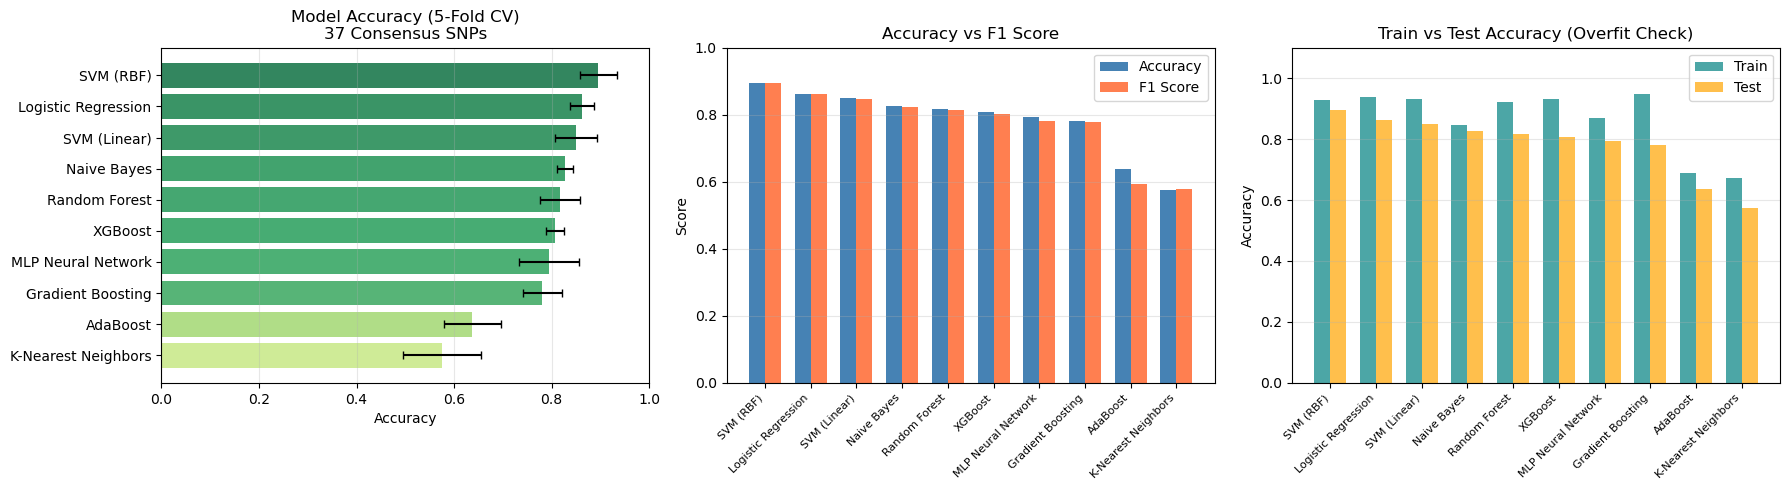

In [10]:
# Visualization of CV results
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Sort by accuracy
sorted_df = cv_results_df.sort_values('Accuracy_Mean', ascending=True)

# Plot 1: Accuracy with error bars
ax = axes[0]
colors_bar = plt.cm.RdYlGn(sorted_df['Accuracy_Mean'].values / sorted_df['Accuracy_Mean'].max())
bars = ax.barh(sorted_df['Model'], sorted_df['Accuracy_Mean'], 
               xerr=sorted_df['Accuracy_Std'], color=colors_bar, capsize=3, alpha=0.8)
ax.set_xlabel('Accuracy')
ax.set_title(f'Model Accuracy ({n_folds}-Fold CV)\n{len(available_consensus)} Consensus SNPs')
ax.set_xlim(0, 1)
ax.grid(True, alpha=0.3, axis='x')

# Plot 2: Accuracy vs F1
ax = axes[1]
x = np.arange(len(cv_results_df))
width = 0.35
ax.bar(x - width/2, cv_results_df['Accuracy_Mean'], width, label='Accuracy', color='steelblue')
ax.bar(x + width/2, cv_results_df['F1_Mean'], width, label='F1 Score', color='coral')
ax.set_xticks(x)
ax.set_xticklabels(cv_results_df['Model'], rotation=45, ha='right', fontsize=8)
ax.set_ylabel('Score')
ax.set_title('Accuracy vs F1 Score')
ax.legend()
ax.set_ylim(0, 1)
ax.grid(True, alpha=0.3, axis='y')

# Plot 3: Train vs Test (Overfit check)
ax = axes[2]
ax.bar(x - width/2, cv_results_df['Train_Accuracy'], width, label='Train', color='teal', alpha=0.7)
ax.bar(x + width/2, cv_results_df['Accuracy_Mean'], width, label='Test', color='orange', alpha=0.7)
ax.set_xticks(x)
ax.set_xticklabels(cv_results_df['Model'], rotation=45, ha='right', fontsize=8)
ax.set_ylabel('Accuracy')
ax.set_title('Train vs Test Accuracy (Overfit Check)')
ax.legend()
ax.set_ylim(0, 1.1)
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

## Step 4: Feature Importance Analysis (RF & LR)

In [11]:
# Train RF and LR on full data for feature importance
rf = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1)
rf.fit(X, y)

lr = LogisticRegression(max_iter=1000, random_state=42, multi_class='multinomial', n_jobs=-1)
lr.fit(X_scaled, y)

# Get feature importances
rf_importance = pd.DataFrame({
    'snp': available_consensus,
    'rf_importance': rf.feature_importances_
}).sort_values('rf_importance', ascending=False)

# LR coefficients (use mean absolute coefficient across classes)
lr_coef_abs = np.abs(lr.coef_).mean(axis=0)
lr_importance = pd.DataFrame({
    'snp': available_consensus,
    'lr_importance': lr_coef_abs
}).sort_values('lr_importance', ascending=False)

# Merge
importance_df = rf_importance.merge(lr_importance, on='snp')
importance_df['rank_rf'] = importance_df['rf_importance'].rank(ascending=False)
importance_df['rank_lr'] = importance_df['lr_importance'].rank(ascending=False)
importance_df['avg_rank'] = (importance_df['rank_rf'] + importance_df['rank_lr']) / 2
importance_df = importance_df.sort_values('avg_rank')

print("Feature Importance (Top 20):")
print("="*70)
display(importance_df.head(20))

Feature Importance (Top 20):


,snp,rf_importance,lr_importance,rank_rf,rank_lr,avg_rank
1,"3:130239945[b37]G,A",0.074242,0.801197,2.0,1.0,1.5
0,"4:101002868[b37]A,T",0.097175,0.584197,1.0,5.0,3.0
2,"12:128054516[b37]C,T",0.053472,0.583623,3.0,6.0,4.5
7,"20:9928437[b37]G,T",0.035822,0.700699,8.0,2.0,5.0
5,"11:130759223[b37]G,T",0.041323,0.505892,6.0,12.0,9.0
13,"16:83272044[b37]C,T",0.028319,0.623678,14.0,4.0,9.0
16,"4:5532600[b37]T,C",0.026727,0.643652,17.0,3.0,10.0
10,"6:37497412[b37]C,T",0.032241,0.526402,11.0,10.0,10.5
3,"16:88769665[b37]T,G",0.046772,0.359354,4.0,19.0,11.5
15,"1:240285457[b37]G,A",0.027253,0.557758,16.0,8.0,12.0


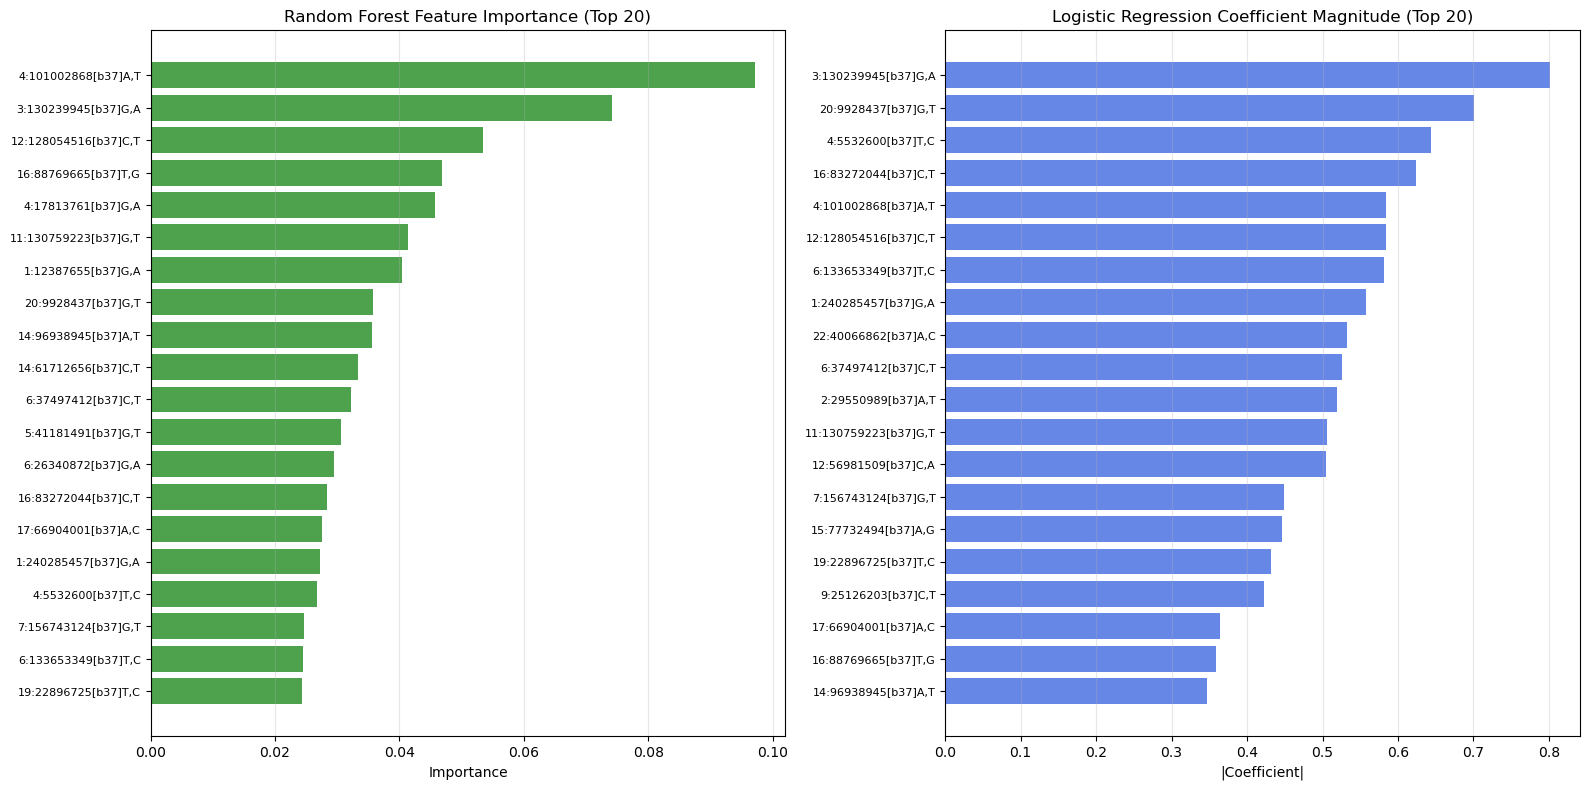

In [12]:
# Feature importance visualization
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Plot 1: RF importance
ax = axes[0]
top_rf = rf_importance.head(20)
ax.barh(range(20), top_rf['rf_importance'].values, color='forestgreen', alpha=0.8)
ax.set_yticks(range(20))
ax.set_yticklabels(top_rf['snp'].values, fontsize=8)
ax.invert_yaxis()
ax.set_xlabel('Importance')
ax.set_title('Random Forest Feature Importance (Top 20)')
ax.grid(True, alpha=0.3, axis='x')

# Plot 2: LR importance
ax = axes[1]
top_lr = lr_importance.head(20)
ax.barh(range(20), top_lr['lr_importance'].values, color='royalblue', alpha=0.8)
ax.set_yticks(range(20))
ax.set_yticklabels(top_lr['snp'].values, fontsize=8)
ax.invert_yaxis()
ax.set_xlabel('|Coefficient|')
ax.set_title('Logistic Regression Coefficient Magnitude (Top 20)')
ax.grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

## Step 5: Test Reduced Feature Sets (5 to 50 SNPs, in steps of 5)

In [ ]:
# Define feature set sizes to test (50 down to 5, in gaps of 5)
feature_sizes = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50]

# Get top SNPs by average rank (RF + LR combined)
top_snps_ordered = importance_df.sort_values('avg_rank')['snp'].tolist()

# Ensure we have enough SNPs
max_features = min(50, len(top_snps_ordered))
feature_sizes = [s for s in feature_sizes if s <= max_features]

print("Testing reduced feature sets...")
print(f"Feature sizes: {feature_sizes}")
print(f"Available SNPs: {len(top_snps_ordered)}")
print(f"\nTop SNPs by combined RF+LR rank:")
for i, snp in enumerate(top_snps_ordered[:min(50, len(top_snps_ordered))], 1):
    print(f"  {i:2d}. {snp}")

Testing reduced feature sets...
Feature sizes: [5, 10, 15, 20, 25]

Top SNPs by combined RF+LR rank:
   1. 3:130239945[b37]G,A
   2. 4:101002868[b37]A,T
   3. 12:128054516[b37]C,T
   4. 20:9928437[b37]G,T
   5. 11:130759223[b37]G,T
   6. 16:83272044[b37]C,T
   7. 4:5532600[b37]T,C
   8. 6:37497412[b37]C,T
   9. 16:88769665[b37]T,G
  10. 1:240285457[b37]G,A
  11. 6:133653349[b37]T,C
  12. 14:96938945[b37]A,T
  13. 22:40066862[b37]A,C
  14. 7:156743124[b37]G,T
  15. 17:66904001[b37]A,C
  16. 5:41181491[b37]G,T
  17. 12:56981509[b37]C,A
  18. 19:22896725[b37]T,C
  19. 6:26340872[b37]G,A
  20. 14:61712656[b37]C,T
  21. 1:12387655[b37]G,A
  22. 4:17813761[b37]G,A
  23. 2:29550989[b37]A,T
  24. 15:77732494[b37]A,G
  25. 9:25126203[b37]C,T


In [14]:
# Test each feature set size with all classifiers
reduced_results = []

for n_features in feature_sizes:
    print(f"\n{'='*70}")
    print(f"Testing with TOP {n_features} SNPs")
    print(f"{'='*70}")
    
    # Get top N SNPs
    top_n_snps = top_snps_ordered[:n_features]
    snp_indices = [available_consensus.index(s) for s in top_n_snps]
    
    X_reduced = X[:, snp_indices]
    X_reduced_scaled = scaler.fit_transform(X_reduced)
    
    for name, clf in classifiers.items():
        # Clone classifier
        clf_clone = clf.__class__(**clf.get_params())
        
        # Select appropriate data
        if 'SVM' in name or 'Logistic' in name or 'MLP' in name:
            X_use = X_reduced_scaled
        else:
            X_use = X_reduced
        
        if 'XGBoost' in name or 'MLP' in name:
            y_use = y_encoded
        else:
            y_use = y
        
        try:
            scores = cross_val_score(clf_clone, X_use, y_use, cv=cv, scoring='accuracy')
            reduced_results.append({
                'N_Features': n_features,
                'Model': name,
                'Accuracy_Mean': scores.mean(),
                'Accuracy_Std': scores.std()
            })
        except Exception as e:
            reduced_results.append({
                'N_Features': n_features,
                'Model': name,
                'Accuracy_Mean': np.nan,
                'Accuracy_Std': np.nan
            })
    
    # Print best model for this feature size
    size_results = [r for r in reduced_results if r['N_Features'] == n_features]
    best = max(size_results, key=lambda x: x['Accuracy_Mean'] if not np.isnan(x['Accuracy_Mean']) else 0)
    print(f"Best: {best['Model']} ({best['Accuracy_Mean']:.4f} ± {best['Accuracy_Std']:.4f})")

reduced_df = pd.DataFrame(reduced_results)
print("\nReduced feature set testing complete!")


Testing with TOP 5 SNPs
Best: AdaBoost (0.6764 ± 0.0525)

Testing with TOP 10 SNPs
Best: Logistic Regression (0.7485 ± 0.0527)

Testing with TOP 15 SNPs
Best: Random Forest (0.8431 ± 0.0225)

Testing with TOP 20 SNPs
Best: SVM (Linear) (0.8432 ± 0.0240)

Testing with TOP 25 SNPs
Best: SVM (RBF) (0.8693 ± 0.0326)

Reduced feature set testing complete!


In [15]:
# Summary table by feature size
print("\n" + "="*80)
print("PERFORMANCE BY FEATURE SET SIZE")
print("="*80)

# Pivot to show models as rows, feature sizes as columns
pivot_df = reduced_df.pivot(index='Model', columns='N_Features', values='Accuracy_Mean')

# Add full feature set (all consensus SNPs)
pivot_df[f'{len(available_consensus)} (All)'] = cv_results_df.set_index('Model')['Accuracy_Mean']

# Reorder columns
cols_order = feature_sizes + [f'{len(available_consensus)} (All)']
pivot_df = pivot_df[cols_order]

display(pivot_df.round(4))

# Find best model for each feature size
print("\nBest Model per Feature Size:")
for col in pivot_df.columns:
    best_model = pivot_df[col].idxmax()
    best_acc = pivot_df[col].max()
    print(f"  {col} SNPs: {best_model} ({best_acc:.4f})")


PERFORMANCE BY FEATURE SET SIZE


N_Features,5,10,15,20,25,37 (All)
Model,,,,,,
AdaBoost,0.6764,0.5618,0.5654,0.6048,0.5944,0.6370
Gradient Boosting,0.6372,0.7122,0.8039,0.8038,0.7777,0.7810
K-Nearest Neighbors,0.3856,0.4902,0.4543,0.5945,0.6043,0.5749
Logistic Regression,0.6731,0.7485,0.8236,0.8300,0.8300,0.8627
MLP Neural Network,0.6666,0.6863,0.7416,0.7451,0.7907,0.7944
Naive Bayes,0.6569,0.7224,0.7517,0.8072,0.8041,0.8268
Random Forest,0.6436,0.7319,0.8431,0.8268,0.7909,0.8169
SVM (Linear),0.6666,0.7124,0.8300,0.8432,0.8595,0.8496
SVM (RBF),0.6632,0.7419,0.8398,0.8366,0.8693,0.8955



Best Model per Feature Size:
  5 SNPs: AdaBoost (0.6764)
  10 SNPs: Logistic Regression (0.7485)
  15 SNPs: Random Forest (0.8431)
  20 SNPs: SVM (Linear) (0.8432)
  25 SNPs: SVM (RBF) (0.8693)
  37 (All) SNPs: SVM (RBF) (0.8955)


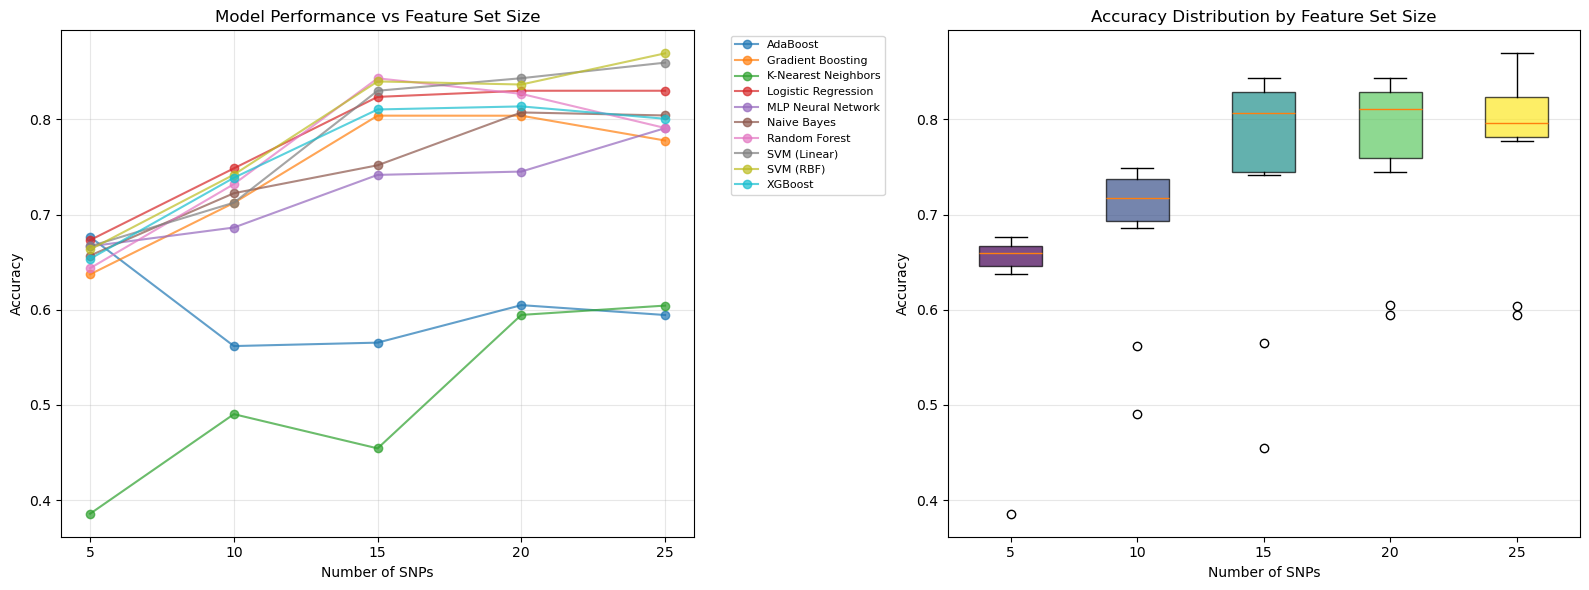

In [16]:
# Visualization: Performance vs Feature Set Size
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Line plot by model
ax = axes[0]
for model in pivot_df.index:
    values = pivot_df.loc[model, feature_sizes].values
    ax.plot(feature_sizes, values, 'o-', label=model, alpha=0.7)

ax.set_xlabel('Number of SNPs')
ax.set_ylabel('Accuracy')
ax.set_title('Model Performance vs Feature Set Size')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
ax.grid(True, alpha=0.3)
ax.set_xticks(feature_sizes)

# Plot 2: Box plot by feature size
ax = axes[1]
box_data = [reduced_df[reduced_df['N_Features'] == n]['Accuracy_Mean'].dropna() for n in feature_sizes]
bp = ax.boxplot(box_data, labels=feature_sizes, patch_artist=True)
colors_box = plt.cm.viridis(np.linspace(0, 1, len(feature_sizes)))
for patch, color in zip(bp['boxes'], colors_box):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)

ax.set_xlabel('Number of SNPs')
ax.set_ylabel('Accuracy')
ax.set_title('Accuracy Distribution by Feature Set Size')
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

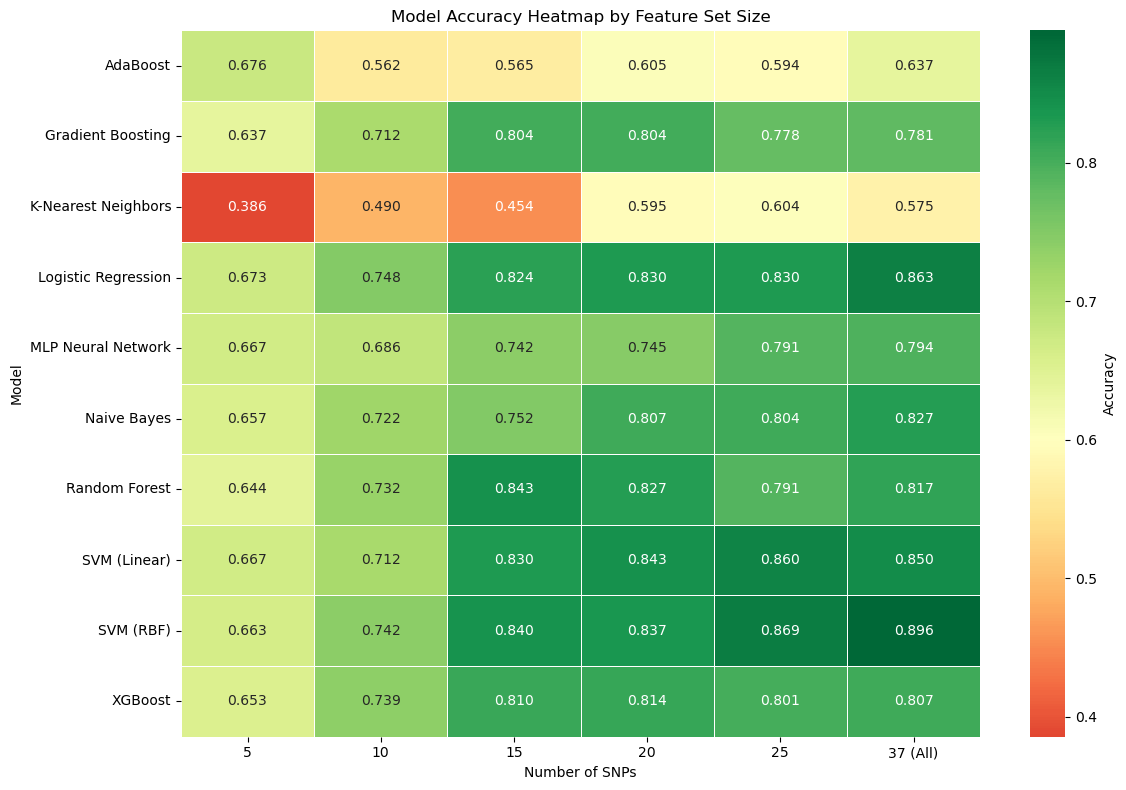

In [17]:
# Heatmap of performance
plt.figure(figsize=(12, 8))

# Add all consensus SNPs column
heatmap_df = pivot_df.copy()

sns.heatmap(heatmap_df, annot=True, fmt='.3f', cmap='RdYlGn', center=0.6,
            linewidths=0.5, cbar_kws={'label': 'Accuracy'})
plt.title('Model Accuracy Heatmap by Feature Set Size')
plt.xlabel('Number of SNPs')
plt.ylabel('Model')
plt.tight_layout()
plt.show()

## Step 6: Save Results

In [18]:
# Save results
output_dir = PATHS.OUTPUT_DIR

# Save CV results on full consensus SNPs
cv_path = str(output_dir / "consensus_snps_cv_results.csv")
cv_results_df.to_csv(cv_path, index=False)
print(f"CV results saved: {cv_path}")

# Save feature importance
importance_path = str(output_dir / "consensus_snps_importance.csv")
importance_df.to_csv(importance_path, index=False)
print(f"Feature importance saved: {importance_path}")

# Save reduced feature set results
reduced_path = str(output_dir / "consensus_snps_reduced_results.csv")
reduced_df.to_csv(reduced_path, index=False)
print(f"Reduced results saved: {reduced_path}")

# Save performance summary by feature size
summary_path = str(output_dir / "consensus_snps_performance_summary.csv")
pivot_df.to_csv(summary_path)
print(f"Performance summary saved: {summary_path}")

# Save consensus SNP list (ordered by importance)
snp_list_path = str(output_dir / "consensus_snps_ranked.txt")
with open(snp_list_path, 'w') as f:
    for i, snp in enumerate(top_snps_ordered, 1):
        f.write(f"{i}\t{snp}\n")
print(f"SNP list saved: {snp_list_path}")

CV results saved: 1000genomes/output/consensus_snps_cv_results.csv
Feature importance saved: 1000genomes/output/consensus_snps_importance.csv
Reduced results saved: 1000genomes/output/consensus_snps_reduced_results.csv
Performance summary saved: 1000genomes/output/consensus_snps_performance_summary.csv
SNP list saved: 1000genomes/output/consensus_snps_ranked.txt


## Summary

In [19]:
print("="*70)
print("CONSENSUS SNP ML TRAINING SUMMARY")
print("="*70)

print(f"\nDataset:")
print(f"  Samples: {len(df)}")
print(f"  Consensus SNPs: {len(available_consensus)}")
print(f"  Populations: {list(le.classes_)}")

print(f"\nPCA (Consensus SNPs):")
print(f"  Variance explained (PC1-3): {sum(pca.explained_variance_ratio_[:3])*100:.1f}%")

print(f"\nBest Model ({len(available_consensus)} SNPs):")
best = cv_results_df.iloc[0]
print(f"  {best['Model']}: {best['Accuracy_Mean']:.4f} ± {best['Accuracy_Std']:.4f}")

print(f"\nTop 5 Most Important SNPs (RF+LR):")
for i, row in importance_df.head(5).iterrows():
    print(f"  {int(row['avg_rank'])}. {row['snp']}")

print(f"\nBest Performance by Feature Set Size:")
for size in feature_sizes:
    size_data = reduced_df[reduced_df['N_Features'] == size]
    best_row = size_data.loc[size_data['Accuracy_Mean'].idxmax()]
    print(f"  {size} SNPs: {best_row['Model']} ({best_row['Accuracy_Mean']:.4f})")

print(f"\nOutput Files:")
print(f"  - consensus_snps_cv_results.csv")
print(f"  - consensus_snps_importance.csv")
print(f"  - consensus_snps_reduced_results.csv")
print(f"  - consensus_snps_performance_summary.csv")
print(f"  - consensus_snps_ranked.txt")

CONSENSUS SNP ML TRAINING SUMMARY

Dataset:
  Samples: 306
  Consensus SNPs: 37
  Populations: ['CHB', 'JPT', 'KHV']

PCA (Consensus SNPs):
  Variance explained (PC1-3): 32.4%

Best Model (37 SNPs):
  SVM (RBF): 0.8955 ± 0.0380

Top 5 Most Important SNPs (RF+LR):
  1. 3:130239945[b37]G,A
  3. 4:101002868[b37]A,T
  4. 12:128054516[b37]C,T
  5. 20:9928437[b37]G,T
  9. 11:130759223[b37]G,T

Best Performance by Feature Set Size:
  5 SNPs: AdaBoost (0.6764)
  10 SNPs: Logistic Regression (0.7485)
  15 SNPs: Random Forest (0.8431)
  20 SNPs: SVM (Linear) (0.8432)
  25 SNPs: SVM (RBF) (0.8693)

Output Files:
  - consensus_snps_cv_results.csv
  - consensus_snps_importance.csv
  - consensus_snps_reduced_results.csv
  - consensus_snps_performance_summary.csv
  - consensus_snps_ranked.txt
